In [3]:
import numpy as np
import cupy as cp
import cupyx.scipy.signal as signal
import scipy
import pandas as pd

import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objs as go
from plotly.subplots import make_subplots

from astropy.modeling import models, fitting
import astropy.units as u
from astropy import constants as const
from astropy.stats import gaussian_sigma_to_fwhm,gaussian_fwhm_to_sigma

import datetime
import pickle
import importlib
import json
import time
import glob

from time_converter import time_converter
from data.eve_const import wavelength_full,line_name,line_window,initial_guess
from gaussian_fit_eve import gaussian_fit_eve


# load in sav file data

In [2]:
eve_full_files=sorted(glob.glob('./data/EVE_sav_full/EVS_L2*.sav'))
len(eve_full_files)

36099

In [20]:
eve_data=[]
for eve_full_file in eve_full_files[:]:
    eve_data.append( scipy.io.readsav(eve_full_file) )

In [3]:
for band_index in range(len(line_name)):
    time_list=[]
    irradiance_list=[]

    #一个sav一个sav读取，因为sav加起来有250G
    for i in range(len(eve_full_files))[:]:
        eve_data=scipy.io.readsav(eve_full_files[i])

        #对于每个sav file，里面有一个小时的数据，每10s一个数据
        for j in range(len(eve_data['yyyydoy'])):
            # time
            yyyydoy=str(eve_data['yyyydoy'][j])
            sod_time=eve_data['sod_time'][j]
            
            # anomaly 先不管这个了
            # flag=np.where(eve_data['sc_flags'][j] == 0, 1, np.nan)*\

            # irrdiance around He II
            irradiance=eve_data['irradiance'][j][line_window[band_index]]
            
            time_list.append(time_converter(yyyydoy,sod_time))
            irradiance_list.append(irradiance)

    #construct dataframe
    original_data={
                    'time':time_list,
                    'irradiance':irradiance_list,
                    }
    original_df=pd.DataFrame(original_data)
    original_df=original_df.set_index('time')

    # save original data
    with open('./data/original_df/original_df_'+line_name[band_index]+'.pkl', 'wb') as file:
        pickle.dump(original_df, file)

In [4]:
# select data range before MEGS-A broke down
for band_index in range(len(line_name)):
    with open('./data/original_df/original_df_'+line_name[band_index]+'.pkl', 'rb') as file:
        original_df=pickle.load(file)
    original_df=original_df[original_df.index<pd.to_datetime('2014-05-26 00:00:00')]
    
    with open('./data/original_df/original_df_'+line_name[band_index]+'.pkl', 'wb') as file:
        pickle.dump(original_df, file)

In [5]:
# replace negative value with nan
def replace_negative_one(x):
    # x[x<0]=np.nan
    x=np.where(x<0, np.nan, x)
    return x
    
for band_index in range(len(line_name)):
    with open('./data/original_df/original_df_'+line_name[band_index]+'.pkl', 'rb') as file:
        original_df=pickle.load(file)

    original_df['irradiance'] = original_df['irradiance'].apply(replace_negative_one)

    with open('./data/original_df/original_df_'+line_name[band_index]+'.pkl', 'wb') as file:
        pickle.dump(original_df, file)

# Overview of irradiance

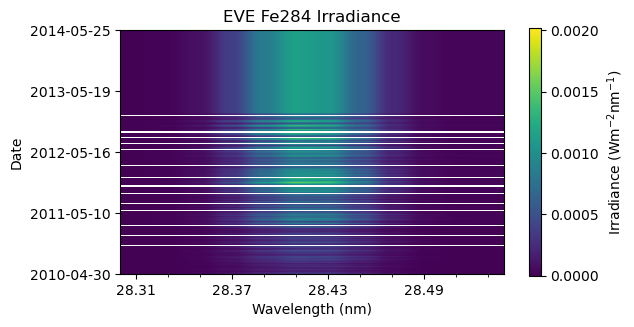

In [6]:
band_index=3
with open('./data/original_df/original_df_'+line_name[band_index]+'.pkl', 'rb') as file:
        original_df=pickle.load(file)

fig,ax=plt.subplots()
irradiance=np.stack(original_df['irradiance'].values)
sc=ax.imshow(irradiance,
             aspect=5e-8 * len(line_window[band_index]),
             origin='lower')

ax.set_xlabel('Wavelength (nm)')
ax.set_xticks(np.arange(len(line_window[band_index])))
ax.set_xticklabels(np.round(wavelength_full[line_window[band_index]],2))
# add minor and major tick of x axis
ax.xaxis.set_major_locator(plt.MultipleLocator(3))
ax.xaxis.set_minor_locator(plt.MultipleLocator(1))

ax.set_ylabel('Date')
ax.set_yticks(np.linspace(0,len(original_df),5))
ax.set_yticklabels([original_df.index[i].date() for i in np.linspace(0,len(original_df)-1,5).astype(int)])

ax.set_title('EVE '+line_name[band_index]+' Irradiance')

cbar = plt.colorbar(sc,shrink=0.55)
cbar.set_label(r'Irradiance ($\rm{W m^{-2} nm^{-1})}$')

plt.tight_layout()
fig.savefig('./output/irradiance_overview/overview_irradiance_'+line_name[band_index]+'.eps'
        #     ,dpi=1000
            )

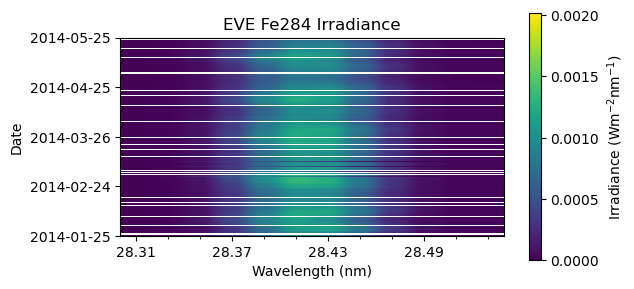

In [50]:
# show the detail of upper one, discovered that some detail in the upper figure is missing

fig,ax=plt.subplots()
irradiance=np.stack(original_df[pd.to_datetime('2014-01-25 00:00:00')<original_df.index]['irradiance'].values)
sc=ax.imshow(irradiance,
             aspect=5e-7 * len(line_window[band_index]),
             origin='lower')

ax.set_xlabel('Wavelength (nm)')
# use this to set x ticklabel: ax.set_xticklabels(wavelength_full[line_window[band_index]])
ax.set_xticks(np.arange(len(line_window[band_index])))
ax.set_xticklabels(np.round(wavelength_full[line_window[band_index]],2))

# add minor and major tick of x axis
ax.xaxis.set_major_locator(plt.MultipleLocator(3))
ax.xaxis.set_minor_locator(plt.MultipleLocator(1))

ax.set_ylabel('Date')
ax.set_yticks(np.linspace(0,len(
    original_df[pd.to_datetime('2014-01-25 00:00:00')<original_df.index]
    ),5))
ax.set_yticklabels([original_df[pd.to_datetime('2014-01-25 00:00:00')<original_df.index].index[i].date() 
                for i in np.linspace(0,len(
                        original_df[pd.to_datetime('2014-01-25 00:00:00')<original_df.index])-1,5).astype(int)])

ax.set_title('EVE '+line_name[band_index]+' Irradiance')

cbar = plt.colorbar(sc,shrink=0.55)
cbar.set_label(r'Irradiance ($\rm{W m^{-2} nm^{-1})}$')

plt.tight_layout()

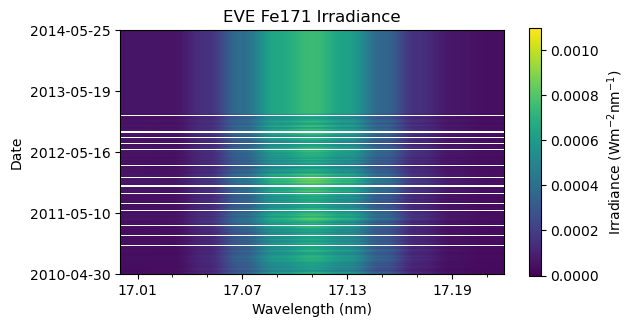

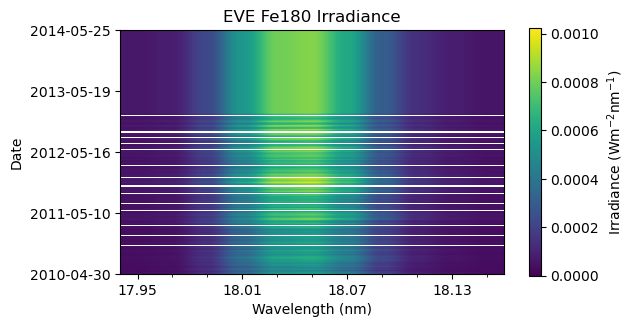

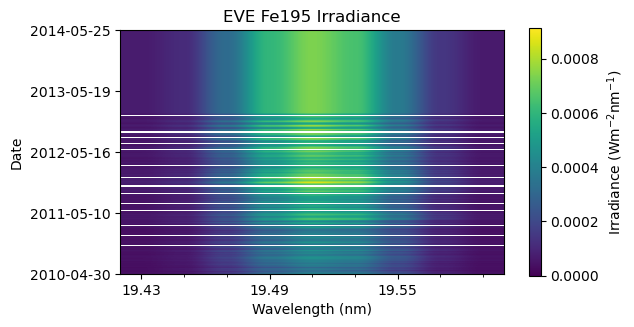

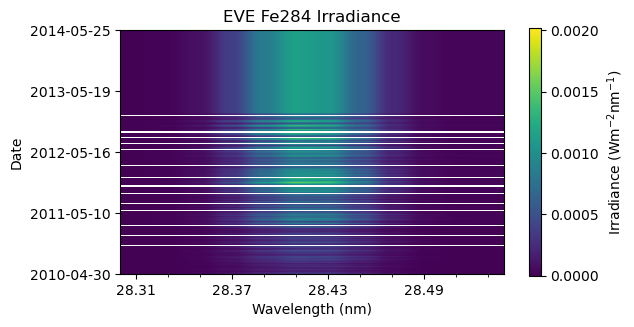

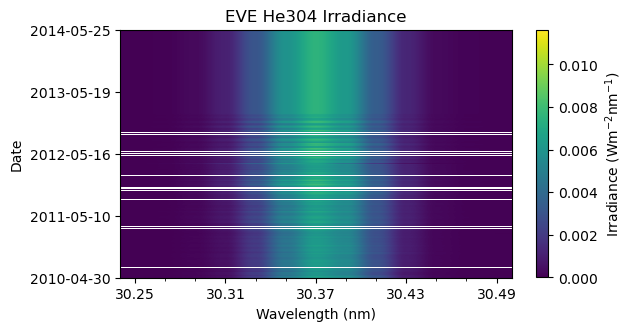

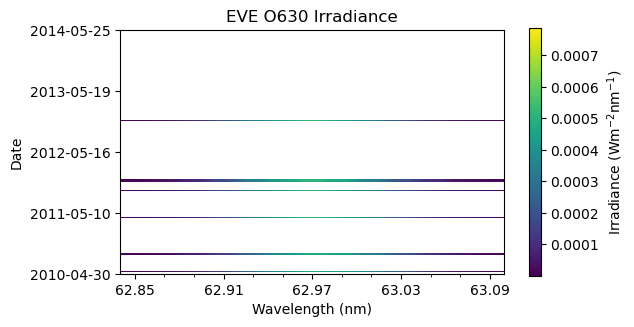

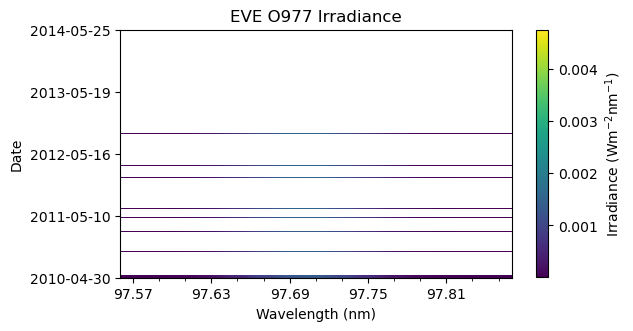

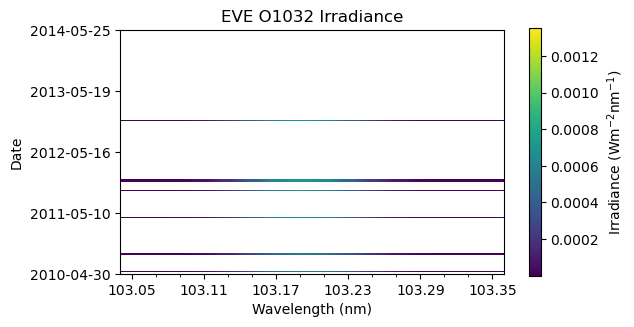

In [7]:
for band_index in range(len(line_name)):
    with open('./data/original_df/original_df_'+line_name[band_index]+'.pkl', 'rb') as file:
        original_df=pickle.load(file)

    fig,ax=plt.subplots()
    irradiance=np.stack(original_df['irradiance'].values)
    sc=ax.imshow(irradiance,
                aspect=5e-8 * len(line_window[band_index]),
                origin='lower')

    ax.set_xlabel('Wavelength (nm)')
    ax.set_xticks(np.arange(len(line_window[band_index])))
    ax.set_xticklabels(np.round(wavelength_full[line_window[band_index]],2))
    # add minor and major tick of x axis
    ax.xaxis.set_major_locator(plt.MultipleLocator(3))
    ax.xaxis.set_minor_locator(plt.MultipleLocator(1))

    ax.set_ylabel('Date')
    ax.set_yticks(np.linspace(0,len(original_df),5))
    ax.set_yticklabels([original_df.index[i].date() for i in np.linspace(0,len(original_df)-1,5).astype(int)])

    ax.set_title('EVE '+line_name[band_index]+' Irradiance')

    cbar = plt.colorbar(sc,shrink=0.55)
    cbar.set_label(r'Irradiance ($\rm{W m^{-2} nm^{-1})}$')

    plt.tight_layout()
    fig.savefig('./output/irradiance_overview/overview_irradiance_'+line_name[band_index]+'.png'
            #     ,dpi=1000
                )

In [13]:
# Valid data and percentage
for band_index in range(len(line_name)):
    with open('./data/original_df/original_df_'+line_name[band_index]+'.pkl', 'rb') as file:
        original_df = pickle.load(file)

    # Convert the 'irradiance' column to float64
    irradiance = np.stack(original_df['irradiance'].values).astype(np.float64)

    # Calculate the percentage of valid data
    valid_data_count = np.sum(irradiance > 0)
    total_data_count = irradiance.size
    valid_data_percentage = (valid_data_count / total_data_count) * 100

    print(f"{line_name[band_index]}\n valid data (above 0): {valid_data_count}\n percentage: {valid_data_percentage}% \n")


Fe171
 valid data (above 0): 136559665
 percentage: 97.92078794016778% 

Fe180
 valid data (above 0): 136559665
 percentage: 97.92078794016778% 

Fe195
 valid data (above 0): 111730635
 percentage: 97.92078794016778% 

Fe284
 valid data (above 0): 148974173
 percentage: 97.92078333906498% 

He304
 valid data (above 0): 161388689
 percentage: 97.9207842997348% 

O630
 valid data (above 0): 27761825
 percentage: 16.844177212394268% 

O977
 valid data (above 0): 32032875
 percentage: 16.844177212394268% 

O1032
 valid data (above 0): 34168400
 percentage: 16.844177212394268% 



# Fit of every 10s

In [3]:
band_index=0
with open('./data/original_df/original_df_'+line_name[band_index]+'.pkl', 'rb') as file:
    original_df = pickle.load(file)

In [5]:
original_df.iloc[0]

irradiance    [4.1993564e-05, 4.1473486e-05, 0.00012016233, ...
Name: 2010-04-30 00:00:00, dtype: object

In [26]:
gaussian_fit_eve(wavelength_full[line_window[band_index]],
                 temp,
                 initial_guess=initial_guess[band_index])

(array([nan, nan, nan]),
 array([[nan, nan, nan],
        [nan, nan, nan],
        [nan, nan, nan]]))

In [5]:
#对所有波段的每10s数据进行拟合，得到amplitude, mean, stddev。实际运行是分为

for band_index in range(len(line_name)):
    with open('./data/original_df/original_df_'+line_name[band_index]+'.pkl', 'rb') as file:
        original_df = pickle.load(file)

    mean_list=[]
    stddev_list=[]
    amp_list=[]
    pcov_list=[]
    time_list=[]

    wavelength_list=wavelength_full[line_window[band_index]]
    p0=initial_guess[band_index]
    i=0
    for key in original_df.index[:3]:
        # popt: fit value
        # pcov: stddev of the fit
        popt,pcov=gaussian_fit_eve(wavelength_list,
                                original_df.loc[key]['irradiance'],
                                initial_guess=p0)
        amplitude, mean, stddev=popt
        time=key  # original_df.iloc[key]['time']


        amp_list.append(amplitude)
        mean_list.append(mean)
        stddev_list.append(stddev)

        pcov_list.append(pcov)
        time_list.append(time)

        # if not np.isnan(cen):
        # print(key,cen)


        i=i+1
        if(i%86400==0):
            print(key,mean)


    fit_df={    'time':time_list,
            'amplitude':amp_list,
            'mean':mean_list,
            'stddev':stddev_list,
            'pcov':pcov_list,
            
                }
                
    fit_df=pd.DataFrame(fit_df)

    with open('./data/fit_10s/fit_10s_'+line_name[band_index]+'.pkl', 'wb') as file:
        pickle.dump(fit_df, file)

## Visualization of data in 10s cadence

In [17]:
# create a new df containing parameters and their errors
para_err=fit_df.apply(lambda x: np.sqrt(np.diag(x['pcov'])),axis=1)

para=fit_df[['amplitude','mean','stddev']].apply(lambda row: np.array(row), axis=1)

# create a df with para,para_err,time
para_df=pd.DataFrame({'para':para,'para_err':para_err,'time':fit_df['time']})
para_df.set_index('time',inplace=True)

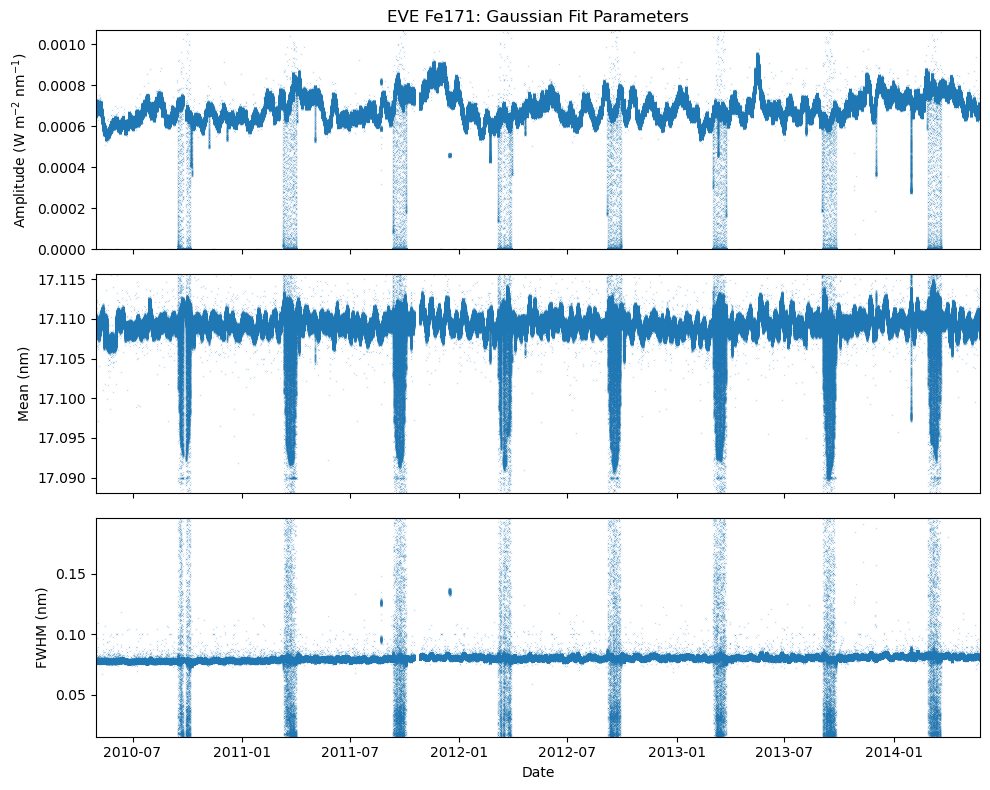

In [20]:
# 3 row 1 column    plot the parameter in 10 s cadence

fig,axs=plt.subplots(3,1,
                     figsize=(10,8),
                     sharex=True,)

axs[0].scatter(para_df.index,np.stack(para_df['para'].values)[:, 0],s=0.003,marker='x',label='amplitude')
# axs[0].scatter(para_df['time'],np.stack(para_df['para_err'].values)[:, 0],s=0.003,marker='x',label='amplitude_err')
axs[0].set_ylabel('Amplitude (W m$^{-2}$ nm$^{-1}$)')

upper_percentile=np.nanpercentile(np.stack(para_df['para'].values)[:, 0],99.9)
axs[0].set_ylim(0.,1.2*upper_percentile)

axs[1].scatter(para_df.index,np.stack(para_df['para'].values)[:, 1],s=0.003,marker='x',label='mean')
# axs[1].scatter(para_df['time'],np.stack(para_df['para_err'].values)[:, 1],s=0.003,marker='x',label='mean_err')
axs[1].set_ylabel('Mean (nm)')
upper_percentile=np.nanpercentile(np.stack(para_df['para'].values)[:, 1],99.8)
lower_percentile=np.nanpercentile(np.stack(para_df['para'].values)[:, 1],0.1)
axs[1].set_ylim(lower_percentile,upper_percentile+0.1*(upper_percentile-lower_percentile))

axs[2].scatter(para_df.index,gaussian_sigma_to_fwhm*np.stack(para_df['para'].values)[:, 2],s=0.003,marker='x',label='stddev')
# axs[2].scatter(para_df['time'],np.stack(para_df['para_err'].values)[:, 2],s=0.003,marker='x',label='stddev_err')
axs[2].set_ylabel('FWHM (nm)')
upper_percentile=np.nanpercentile(gaussian_sigma_to_fwhm*np.stack(para_df['para'].values)[:, 2],99.95)
lower_percentile=np.nanpercentile(gaussian_sigma_to_fwhm*np.stack(para_df['para'].values)[:, 2],0.05)
axs[2].set_ylim(lower_percentile,upper_percentile)

axs[2].set_xlabel('Date')
# axs[2].set_xlim(para_df['time'].iloc[0],para_df['time'].iloc[-1])

axs[0].set_title('EVE '+line_name[band_index]+': Gaussian Fit Parameters')

axs[0].set_xlim(para_df.index[0],para_df.index[-1])
    
plt.tight_layout()
fig.savefig('output/cadence_10s/cadence_10s_'+line_name[band_index]+'.png'
            # dpi=400
            )

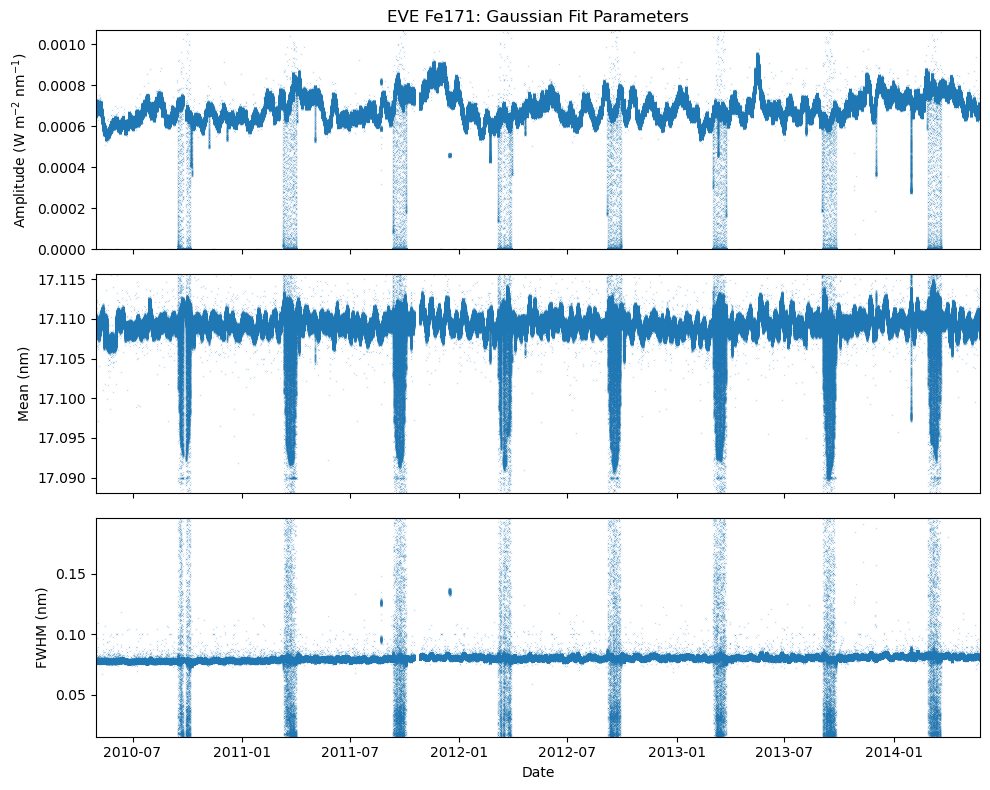

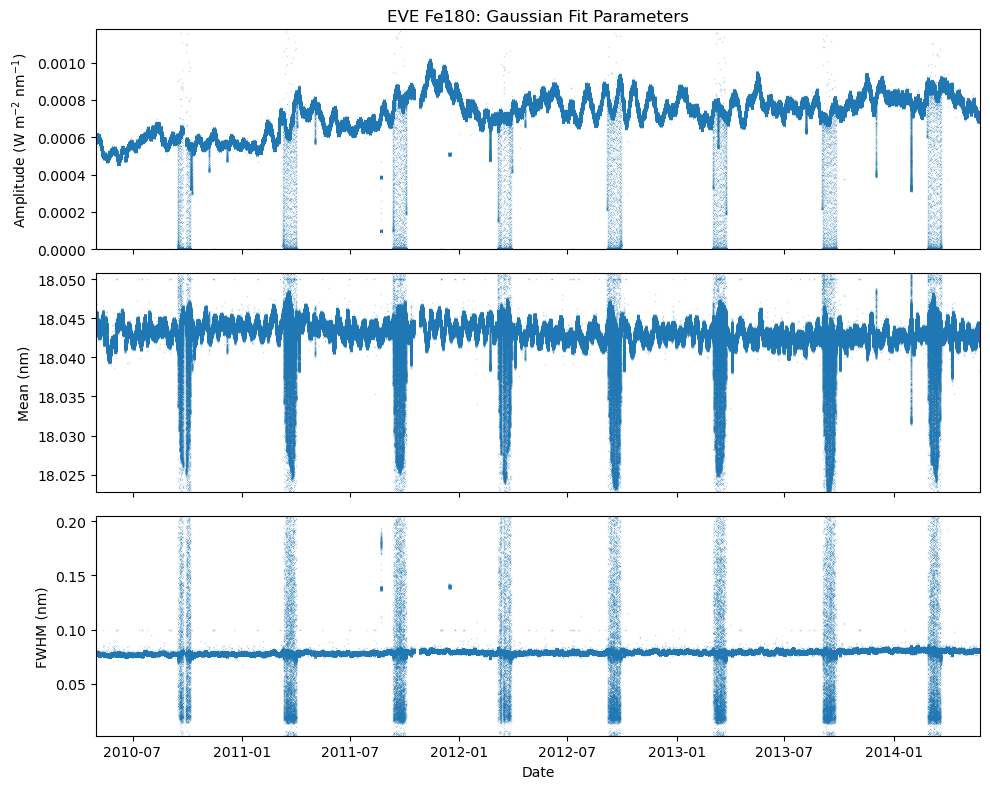

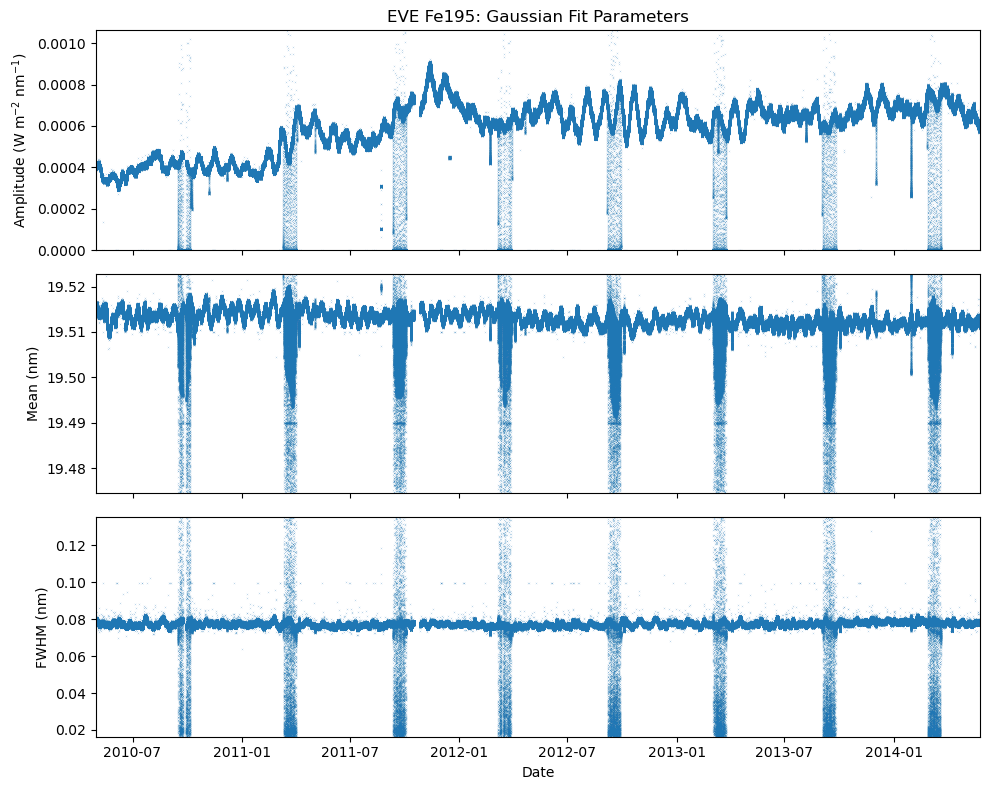

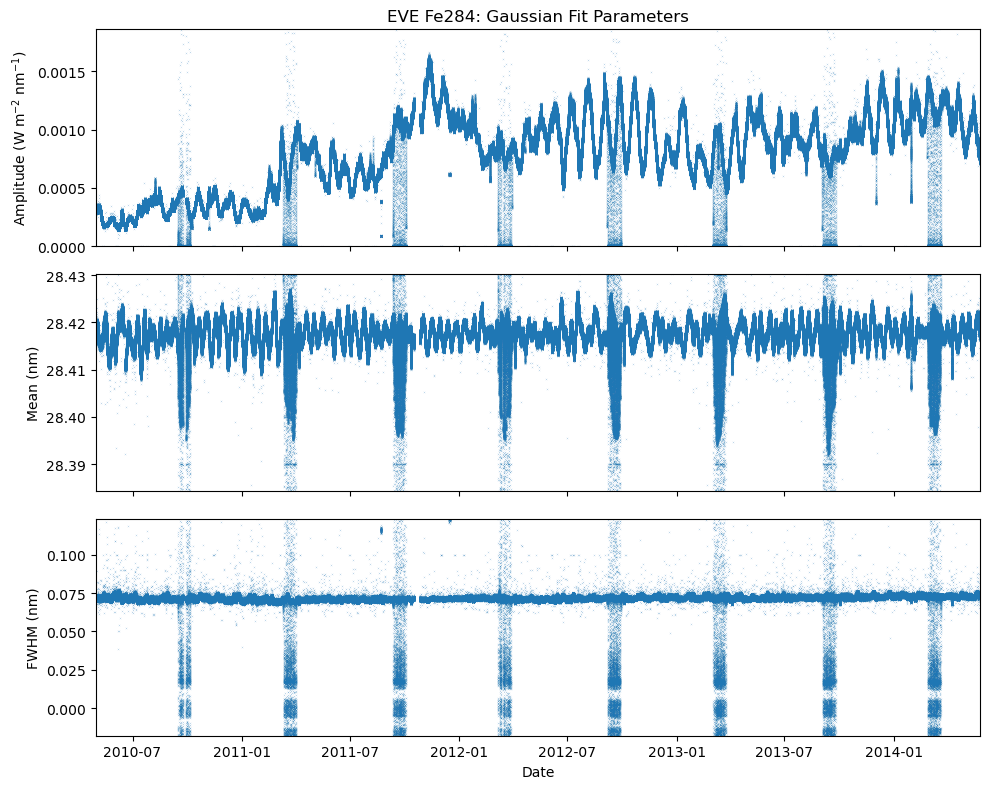

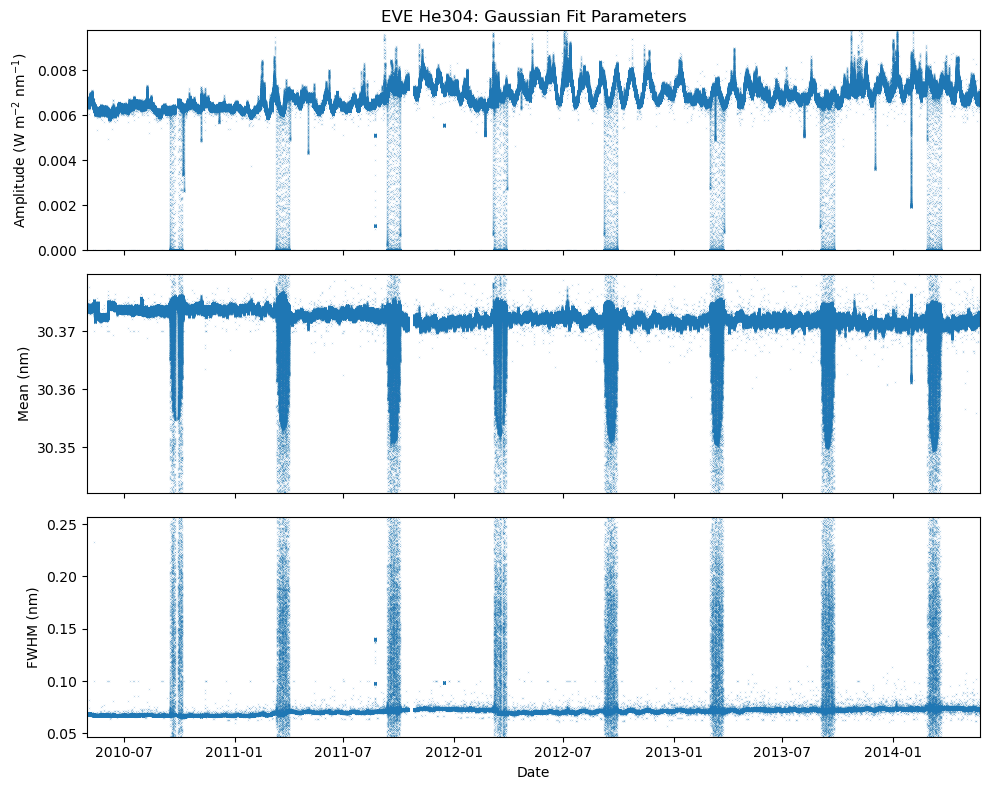

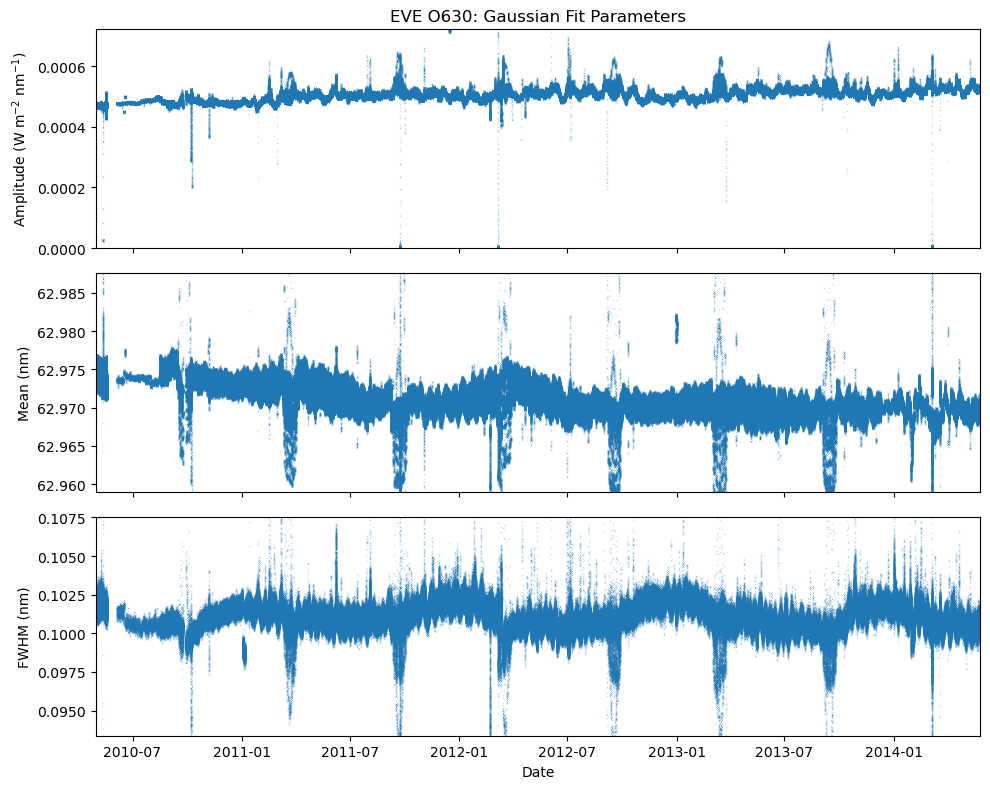

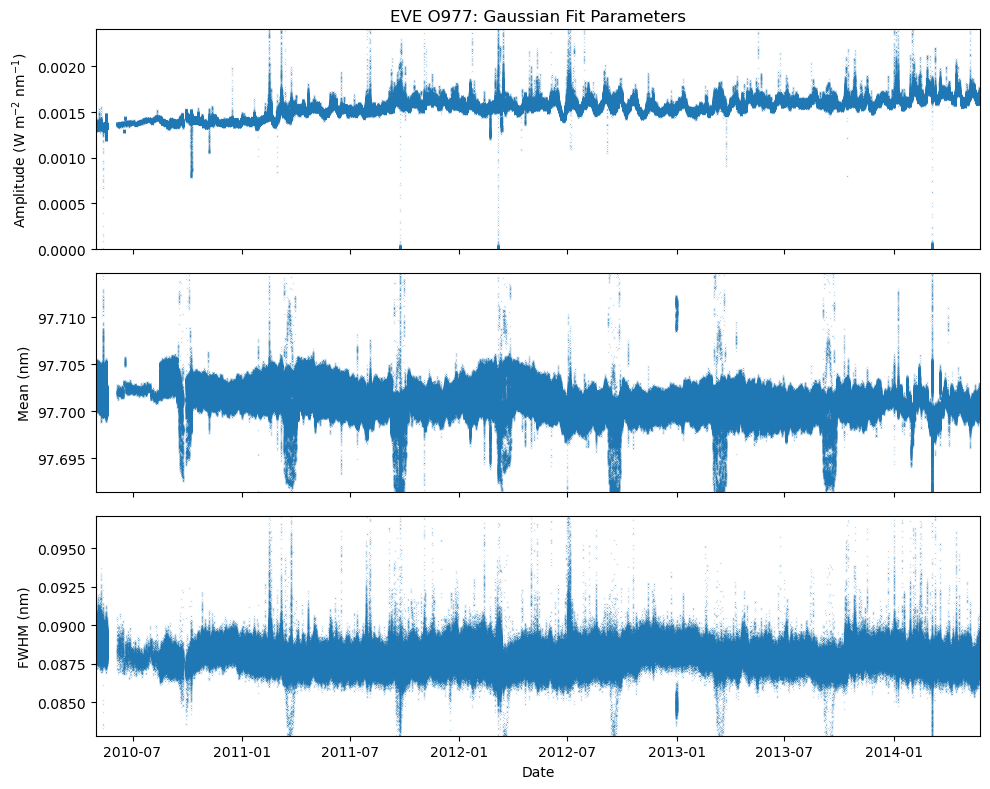

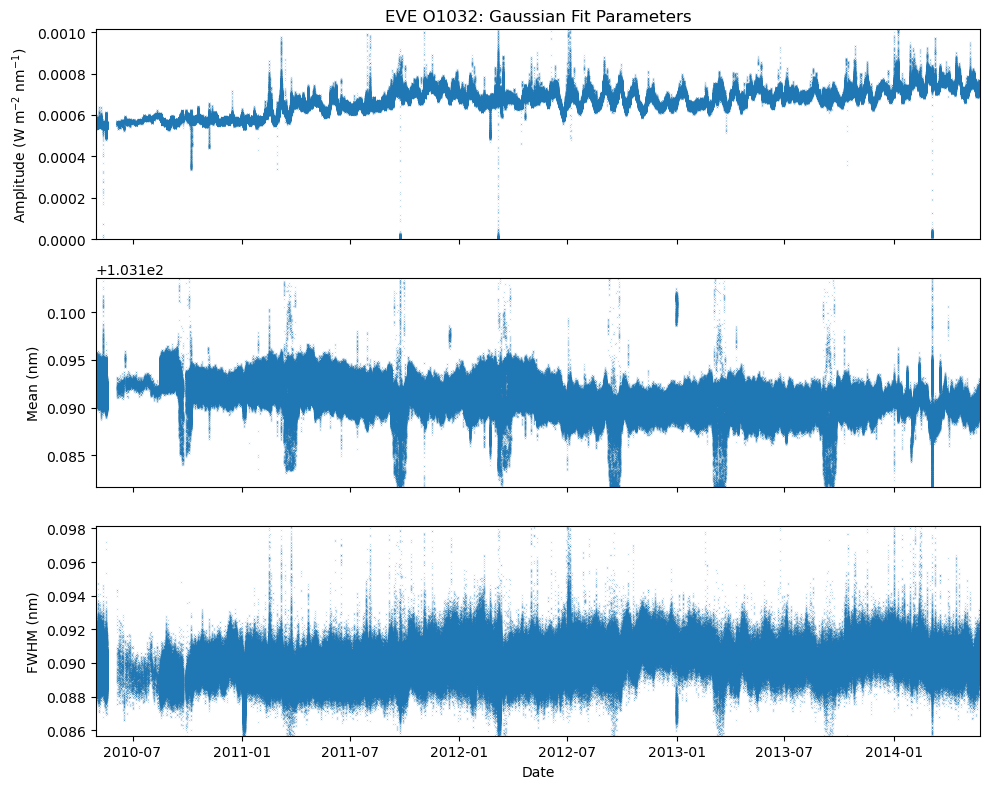

In [5]:
for band_index in range(len(line_name))[:]:
    with open('./data/fit_10s/fit_10s_'+line_name[band_index]+'.pkl', 'rb') as file:
        fit_df=pickle.load(file)

        
    para_err=fit_df.apply(lambda x: np.sqrt(np.diag(x['pcov'])),axis=1)
    para=fit_df[['amplitude','mean','stddev']].apply(lambda row: np.array(row), axis=1)

    # create a df with para,para_err,time
    para_df=pd.DataFrame({'para':para,'para_err':para_err,'time':fit_df['time']})
    para_df.set_index('time',inplace=True)
    
    fig,axs=plt.subplots(3,1,
                    figsize=(10,8),
                    sharex=True,)

    axs[0].scatter(para_df.index,np.stack(para_df['para'].values)[:, 0],s=0.003,marker='x',label='amplitude')
    # axs[0].scatter(para_df['time'],np.stack(para_df['para_err'].values)[:, 0],s=0.003,marker='x',label='amplitude_err')
    axs[0].set_ylabel('Amplitude (W m$^{-2}$ nm$^{-1}$)')

    upper_percentile=np.nanpercentile(np.stack(para_df['para'].values)[:, 0],99.9)
    axs[0].set_ylim(0.,1.2*upper_percentile)

    axs[1].scatter(para_df.index,np.stack(para_df['para'].values)[:, 1],s=0.003,marker='x',label='mean')
    # axs[1].scatter(para_df['time'],np.stack(para_df['para_err'].values)[:, 1],s=0.003,marker='x',label='mean_err')
    axs[1].set_ylabel('Mean (nm)')
    upper_percentile=np.nanpercentile(np.stack(para_df['para'].values)[:, 1],99.8)
    lower_percentile=np.nanpercentile(np.stack(para_df['para'].values)[:, 1],0.1)
    axs[1].set_ylim(lower_percentile,upper_percentile+0.1*(upper_percentile-lower_percentile))

    axs[2].scatter(para_df.index,gaussian_sigma_to_fwhm*np.stack(para_df['para'].values)[:, 2],s=0.003,marker='x',label='stddev')
    # axs[2].scatter(para_df['time'],np.stack(para_df['para_err'].values)[:, 2],s=0.003,marker='x',label='stddev_err')
    axs[2].set_ylabel('FWHM (nm)')
    upper_percentile=np.nanpercentile(gaussian_sigma_to_fwhm*np.stack(para_df['para'].values)[:, 2],99.95)
    lower_percentile=np.nanpercentile(gaussian_sigma_to_fwhm*np.stack(para_df['para'].values)[:, 2],0.05)
    axs[2].set_ylim(lower_percentile,upper_percentile)

    axs[2].set_xlabel('Date')
    # axs[2].set_xlim(para_df['time'].iloc[0],para_df['time'].iloc[-1])

    axs[0].set_title('EVE '+line_name[band_index]+': Gaussian Fit Parameters')

    axs[0].set_xlim(para_df.index[0],para_df.index[-1])
        
    plt.tight_layout()
    fig.savefig('output/cadence_10s/cadence_10s_'+line_name[band_index]+'.png'
                # dpi=400
                )

### errors of fit

In [6]:
for band_index in range(len(line_name))[:]:
    with open('./data/fit_10s/fit_10s_'+line_name[band_index]+'.pkl', 'rb') as file:
        fit_df=pickle.load(file)

    para_err=fit_df.apply(lambda x: np.sqrt(np.diag(x['pcov'])),axis=1)
    para=fit_df[['amplitude','mean','stddev']].apply(lambda row: np.array(row), axis=1)

    # create a df with para,para_err,time
    para_df=pd.DataFrame({'para':para,'para_err':para_err,'time':fit_df['time']})
    para_df.set_index('time',inplace=True)


    fig,axs=plt.subplots(3,1,figsize=(10,8),sharex=True,)
    # axs[0].scatter(para_df['time'],np.stack(para_df['para'].values)[:, 0],marker='x',label='amplitude')
    axs[0].scatter(para_df.index,np.stack(para_df['para_err'].values)[:, 0],s=0.3,marker='x',label='amplitude_err')
    axs[0].set_ylabel('amplitude fit error')

    upper_percentile=np.nanpercentile(np.stack(para_df['para_err'].values)[:, 0],99.9)
    axs[0].set_ylim(0,4*upper_percentile)

    # axs[1].scatter(para_df['time'],np.stack(para_df['para'].values)[:, 1],marker='x',label='mean')
    axs[1].scatter(para_df.index,np.stack(para_df['para_err'].values)[:, 1],s=0.3,marker='x',label='mean_err')
    axs[1].set_ylabel('mean fit error')

    upper_percentile=np.nanpercentile(np.stack(para_df['para_err'].values)[:, 1],99)
    axs[1].set_ylim(0,3*upper_percentile)


    # axs[2].scatter(para_df['time'],np.stack(para_df['para'].values)[:, 2],marker='x',label='stddev')
    axs[2].scatter(para_df.index,np.stack(para_df['para_err'].values)[:, 2],s=0.3,marker='x',label='stddev_err')
    axs[2].set_ylabel('stddev fit error')

    upper_percentile=np.nanpercentile(np.stack(para_df['para_err'].values)[:, 2],99)
    axs[2].set_ylim(0,3*upper_percentile)

    axs[2].set_xlabel('Date')
    axs[0].set_title('EVE '+line_name[band_index]+': Gaussian Fit Error')
    axs[0].set_xlim(para_df.index[0],para_df.index[-1])
    plt.tight_layout()
    plt.savefig('output/cadence_10s/fitting_error/fit_err_'+line_name[band_index]+'.png')
    # close the figure
    plt.close(fig)

# Aggregate from 10s to 1 day

In [2]:
band_index=0
with open('./data/fit_10s/fit_10s_'+line_name[band_index]+'.pkl', 'rb') as file:
    fit_df = pickle.load(file)

In [5]:
fit_df.set_index('time',inplace=True)
fit_df

amplitude       mean    stddev  \
time                                                  
2010-04-30 00:00:00   0.000663  17.109246  0.033278   
2010-04-30 00:00:10   0.000674  17.109542  0.032737   
2010-04-30 00:00:20   0.000668  17.109403  0.033086   
2010-04-30 00:00:30   0.000685  17.109893  0.032940   
2010-04-30 00:00:40   0.000665  17.109862  0.033110   
...                        ...        ...       ...   
2014-05-25 23:59:19   0.000677  17.109018  0.033913   
2014-05-25 23:59:29   0.000678  17.108852  0.033795   
2014-05-25 23:59:39   0.000679  17.108285  0.033893   
2014-05-25 23:59:49   0.000672  17.109311  0.034305   
2014-05-25 23:59:59   0.000667  17.108730  0.034643   

                                                                  pcov  
time                                                                    
2010-04-30 00:00:00  [[1.6755360877989227e-10, -4.9101018400106667e...  
2010-04-30 00:00:10  [[1.7380618892566927e-10, -1.075925305546174e-...  
2010-04-30 00:00:20  [[1.65379965997518e-10, -7.678134410166929e-14...  
2010-04-30 00:00:30  [[1.589981660740449e-10, -1.2250656156344907e-...  
2010-04-30 00:00:40  [[1.658200994952096e-10, -1.264577504414226e-1...  
...                                                                ...  
2014-05-25 23:59:19  [[2.2847650036625548e-10, 5.793336063950471e-1...  
2014-05-25 23:59:29  [[2.4753060711490993e-10, 8.622094133849973e-1...  
2014-05-25 23:59:39  [[2.5028738864078377e-10, 2.651686055058514e-1...  
2014-05-25 23:59:49  [[2.6199383488070666e-10, 3.515872261773882e-1...  
2014-05-25 23:59:59  [[2.2656518836225192e-10, 3.073611928134007e-1...  

[12678120 rows x 4 columns]

In [6]:
fit_df['mean'].resample('D').agg(np.nanstd)

time
2010-04-30    0.000304
2010-05-01    0.000330
2010-05-02    0.000401
2010-05-03    0.000371
2010-05-04    0.000334
                ...   
2014-05-21    0.000388
2014-05-22    0.000441
2014-05-23    0.000333
2014-05-24    0.000516
2014-05-25    0.000651
Freq: D, Name: mean, Length: 1487, dtype: float64

In [12]:
def f(x):
    y=np.size(x)-np.sum(np.isnan(x))
    return y
        
for band_index in range(len(line_name)):
    with open('./data/fit_10s/fit_10s_'+line_name[band_index]+'.pkl', 'rb') as file:
        fit_df = pickle.load(file)
    fit_df.set_index('time',inplace=True)


    stddev_of_mean=fit_df['mean'].resample('D').agg(np.nanstd)
    stddev_of_stddev=fit_df['stddev'].resample('D').agg(np.nanstd)
    stddev_of_amplitude=fit_df['amplitude'].resample('D').agg(np.nanstd)
    available_data=fit_df['amplitude'].resample('D').agg(f)


    columns_to_agg = ['amplitude', 'mean', 'stddev']
    daily_median = fit_df[columns_to_agg].resample('D').agg(np.nanmedian)

    # Create a new DataFrame 'daily_fit_df' to store the daily median, stddev, and amplitude
    # fwhm=2.3*stddev
    daily_df = pd.DataFrame()
    daily_df['median_of_mean'] = daily_median['mean']
    daily_df['median_of_stddev'] = daily_median['stddev']
    daily_df['median_of_amplitude'] = daily_median['amplitude']

    daily_df['stddev_of_mean']=stddev_of_mean
    daily_df['stddev_of_stddev']=stddev_of_stddev
    daily_df['stddev_of_amplitude']=stddev_of_amplitude

    daily_df['available_data']=available_data

    # save daily_df
    with open('./data/daily_df/daily_df_'+line_name[band_index]+'.pkl', 'wb') as file:
        pickle.dump(daily_df, file)


In [13]:
with open('./data/daily_df/daily_df_'+line_name[band_index]+'.pkl', 'rb') as file:
    daily_df = pickle.load(file)

In [14]:
daily_df

median_of_mean  median_of_stddev  median_of_amplitude  \
time                                                                
2010-04-30      103.192636          0.038124             0.000552   
2010-05-01      103.192563          0.038134             0.000556   
2010-05-02      103.192624          0.038139             0.000553   
2010-05-03      103.192535          0.038152             0.000553   
2010-05-04      103.192385          0.038216             0.000558   
...                    ...               ...                  ...   
2014-05-21      103.190078          0.038266             0.000712   
2014-05-22      103.190083          0.038222             0.000709   
2014-05-23      103.190307          0.038303             0.000714   
2014-05-24      103.190462          0.038426             0.000726   
2014-05-25      103.190491          0.038426             0.000717   

            stddev_of_mean  stddev_of_stddev  stddev_of_amplitude  \
time                                                                
2010-04-30        0.001265          0.000264             0.000006   
2010-05-01        0.001268          0.000273             0.000005   
2010-05-02        0.001292          0.000256             0.000005   
2010-05-03        0.001245          0.000286             0.000006   
2010-05-04        0.001319          0.000409             0.000007   
...                    ...               ...                  ...   
2014-05-21        0.000886          0.000358             0.000009   
2014-05-22        0.000806          0.000333             0.000008   
2014-05-23        0.000750          0.000350             0.000008   
2014-05-24        0.000802          0.000357             0.000015   
2014-05-25        0.000808          0.000335             0.000010   

            available_data  
time                        
2010-04-30            8498  
2010-05-01            8508  
2010-05-02            8508  
2010-05-03            8580  
2010-05-04            8384  
...                    ...  
2014-05-21            1108  
2014-05-22            1108  
2014-05-23            1108  
2014-05-24            1108  
2014-05-25            1108  

[1487 rows x 7 columns]